# Automation

In [8]:
def basic_wrangling(df, features=[], missing_threshold=0.95, unique_threshold=0.95, messages=True):
  import pandas as pd

  if len(features) == 0: features = df.columns

  for feat in features:
    if feat in df.columns:
      missing = df[feat].isna().sum()
      unique = df[feat].nunique()
      rows = df.shape[0]

      if missing / rows >= missing_threshold:
        if messages: print(f"Too much missing ({missing} out of {rows}, {round(missing/rows, 0)}) for {feat}")
        df.drop(columns=[feat], inplace=True)
      elif unique / rows >= unique_threshold:
        if df[feat].dtype in ['int64', 'object']:
          if messages: print(f"Too many unique values ({unique} out of {rows}, {round(unique/rows, 0)}) for {feat}")
          df.drop(columns=[feat], inplace=True)
      elif unique == 1:
        if messages: print(f"Only one value ({df[feat].unique()[0]}) for {feat}")
        df.drop(columns=[feat], inplace=True)
    else:
      if messages: print(f"The feature \"{feat}\" doesn't exist as spelled in the DataFrame provided")

  return df

def parse_dates(df, features=[], days_since_today=True, drop_date=False, messages=True, today_date=None, future=False):
  import pandas as pd
  from datetime import datetime as dt

  if today_date is None:
    today_date = dt.today()

  today_date = pd.to_datetime(today_date) 

  if future == False:
    for col in features:
      if col in df.columns:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_weekday'] = df[col].dt.day_name()

        if days_since_today: 
          df[f'{col}_days_since_{today_date.date()}'] = (today_date - df[col]).dt.days 
        if drop_date:
          df.drop(columns=[col], inplace=True)
      else:
        if messages:
          print(f'The feature name you provided ({col}) is not in the DataFrame')
  else:
    for col in features:
      if col in df.columns:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_weekday'] = df[col].dt.day_name()

        if days_since_today: 
          df[f'{col}_days_until_{today_date.date()}'] = (df[col] - today_date).dt.days 
        if drop_date:
          df.drop(columns=[col], inplace=True)
      else:
        if messages:
          print(f'The feature name you provided ({col}) is not in the DataFrame')

  return df

def bin_categories(df, features=[], cutoff=0.05, replace_with="Other", messages=True):
  import pandas as pd

  if len(features) == 0: features = df.columns

  for feat in features:
    if feat in df.columns:
      if not pd.api.types.is_numeric_dtype(df[feat]):
        # Filter the value_counts list down to those < 0.05 and keep the index names
        other_list = df[feat].value_counts()[df[feat].value_counts() / df.shape[0] < cutoff].index
        # Replace rare categories with the specified label (default: "Other")
        df.loc[df[feat].isin(other_list), feat] = replace_with
        if messages: print(df[feat].value_counts() / df.shape[0])
    else:
      if messages:
        print(f"{feat} not found in columns")

  return df
def scatterplot(df, feature, label, roundto=3, linecolor='darkorange'):
  import pandas as pd
  from matplotlib import pyplot as plt
  import seaborn as sns
  from scipy import stats

  # Create the plot
  sns.regplot(x=df[feature], y=df[label], line_kws={"color": linecolor})

  # Calculate the regression line so that we can print the text
  m, b, r, p, err = stats.linregress(df[feature], df[label])

  # Add all descriptive statistics to the diagram
  textstr  = 'Regression line:' + '\n'
  textstr += 'y  = ' + str(round(m, roundto)) + 'x + ' + str(round(b, roundto)) + '\n'
  textstr += 'r   = ' + str(round(r, roundto)) + '\n'
  textstr += 'r2 = ' + str(round(r**2, roundto)) + '\n'
  textstr += 'p  = ' + str(round(p, roundto)) + '\n\n'

  plt.text(1, 0.1, textstr, fontsize=12, transform=plt.gcf().transFigure)
  plt.show()


def bar_chart(df, feature, label, roundto=3):
  import pandas as pd
  from scipy import stats
  from matplotlib import pyplot as plt
  import seaborn as sns

  # Handle missing data
  df_temp = df[[feature, label]]
  df_temp = df_temp.dropna()

  sns.barplot(df_temp, x=feature, y=label)

  # Create the label lists needed to calculate oneway-ANOVA F
  groups = df_temp[feature].unique()
  group_lists = []
  for g in groups:
    g_list = df_temp[df_temp[feature] == g][label]
    group_lists.append(g_list)

  results = stats.f_oneway(*group_lists)
  F = results[0]
  p = results[1]

  # Next, calculate t-tests with Bonferroni correction for p-value threshold
  ttests = []
  for i1, g1 in enumerate(groups): # Use the enumerate() function to add an index for counting to a list of values
    # For each item, loop through a second list of each item to compare each pair
    for i2, g2 in enumerate(groups):
      if i2 > i1: # If the inner_index is greater that the outer_index, then go ahead and run a t-test
        type_1 = df_temp[df_temp[feature] == g1]
        type_2 = df_temp[df_temp[feature] == g2]
        t, p = stats.ttest_ind(type_1[label], type_2[label])

        # Add each t-test result to a list of t, p pairs
        ttests.append([str(g1) + ' - ' + str(g2), round(t, roundto), round(p, roundto)])

  p_threshold = 0.05 / len(ttests) # Bonferroni-corrected p-value determined

  # Add all descriptive statistics to the diagram
  textstr  = '   ANOVA' + '\n'
  textstr += 'F: ' + str(round(F, roundto)) + '\n'
  textstr += 'p: ' + str(round(p, roundto)) + '\n\n'

  # Only include the significant t-tests in the printed results for brevity
  for ttest in ttests:
    if ttest[2] <= p_threshold:
      if 'Sig. comparisons (Bonferroni-corrected)' not in textstr: # Only include the header if there is at least one significant result
        textstr += 'Sig. comparisons (Bonferroni-corrected)' + '\n'
      textstr += str(ttest[0]) + ": t=" + str(ttest[1]) + ", p=" + str(ttest[2]) + '\n'

  plt.text(1, 0.1, textstr, fontsize=12, transform=plt.gcf().transFigure)
  plt.xticks(rotation=90)
  plt.show()
  
def crosstab(df, feature, label, roundto=3):
  import pandas as pd
  from scipy.stats import chi2_contingency
  from matplotlib import pyplot as plt
  import seaborn as sns
  import numpy as np

  # Handle missing data
  df_temp = df[[feature, label]]
  df_temp = df_temp.dropna()

  # Bin categories
  df_temp = bin_categories(df_temp, feature)

  # Generate the crosstab table required for X2
  crosstab = pd.crosstab(df_temp[feature], df_temp[label])

  # Calculate X2 and p-value
  X, p, dof, contingency_table = chi2_contingency(crosstab)

  textstr  = 'X2: ' + str(round(X, 4))+ '\n'
  textstr += 'p = ' + str(round(p, 4)) + '\n'
  textstr += 'dof  = ' + str(dof)
  plt.text(0.9, 0.1, textstr, fontsize=12, transform=plt.gcf().transFigure)

  ct_df = pd.DataFrame(np.rint(contingency_table).astype('int64'), columns=crosstab.columns, index=crosstab.index)
  sns.heatmap(ct_df, annot=True, fmt='d', cmap='coolwarm')
  plt.show()

def univariate_stats(df):
    import pandas as pd

    df_results = pd.DataFrame(columns=['dtype', 'count', 'missing', 'unique', 'mode', 'min', 'q1', 
                                       'median', 'q3', 'max', 'mean', 'std', 'skew', 'kurt'])

    for col in df.columns:
        
        dtype = df[col].dtype # property so no parenthsis () needed
        count = df[col].count()
        missing = df[col].isna().sum()
        unique = df[col].nunique()
        mode = df[col].mode()[0] # Returns a tuple so we gotta do it by references

        if pd.api.types.is_numeric_dtype(df[col]):
            min = df[col].min()
            q1 = df[col].quantile(0.25)
            median = df[col].median()
            q3 = df[col].quantile(0.75)
            max = df[col].max()
            mean = df[col].mean()
            std = df[col].std()
            skew = df[col].skew()
            kurt = df[col].kurt()

            df_results.loc[col] = [dtype, count, missing, unique, mode, min, q1, median, q3, max, mean, std, skew, kurt]
        
        else:
            df_results.loc[col] = [dtype, count, missing, unique, mode, '-', '-', '-', '-', '-', '-', '-', '-', '-']

    return df_results

def bivariate(df, label, roundto=4):
  import pandas as pd
  from scipy import stats

  output_df = pd.DataFrame(columns=['missing', 'p', 'r', 'τ', 'ρ', 'y = m(x) + b', 'F', 'X2', 'skew', 'unique', 'values'])

  for feature in df.columns:
    if feature != label:
      df_temp = df[[feature, label]]
      df_temp = df_temp.dropna()
      missing = (df.shape[0] - df_temp.shape[0]) / df.shape[0]
      unique = df_temp[feature].nunique()

      # Bin categories
      if not pd.api.types.is_numeric_dtype(df_temp[feature]):
        df = bin_categories(df, feature)

      if pd.api.types.is_numeric_dtype(df_temp[feature]) and pd.api.types.is_numeric_dtype(df_temp[label]):
        m, b, r, p, err = stats.linregress(df_temp[feature], df_temp[label])
        tau, tp = stats.kendalltau(df_temp[feature], df_temp[label])
        rho, rp = stats.spearmanr(df_temp[feature], df_temp[label])
        output_df.loc[feature] = [f'{missing:.2%}', round(p, roundto), round(r, roundto), round(tau, roundto),
                                  round(rho, roundto), f'y = {round(m, roundto)}(x) + {round(b, roundto)}', '-', '-',
                                  df_temp[feature].skew(), unique, '-']

        scatterplot(df_temp, feature, label, roundto) # Call the scatterplot function
      elif not pd.api.types.is_numeric_dtype(df_temp[feature]) and not pd.api.types.is_numeric_dtype(df_temp[label]):
        contingency_table = pd.crosstab(df_temp[feature], df_temp[label])
        X2, p, dof, expected = stats.chi2_contingency(contingency_table)
        output_df.loc[feature] = [f'{missing:.2%}', round(p, roundto), '-', '-', '-', '-', '-', round(X2, roundto), '-',
                                  unique, df_temp[feature].unique()]

        crosstab(df_temp, feature, label, roundto) # Call the crosstab function
      else:
        if pd.api.types.is_numeric_dtype(df_temp[feature]):
          skew = df_temp[feature].skew()
          num = feature
          cat = label
        else:
          skew = '-'
          num = label
          cat = feature

        groups = df_temp[cat].unique()
        group_lists = []
        for g in groups:
          g_list = df_temp[df_temp[cat] == g][num]
          group_lists.append(g_list)

        results = stats.f_oneway(*group_lists)
        F = results[0]
        p = results[1]
        output_df.loc[feature] = [f'{missing:.2%}', round(p, roundto), '-', '-', '-', '-', round(F, roundto), '-', skew,
                                  unique, df_temp[cat].unique()]

        bar_chart(df_temp, cat, num, roundto) # Call the barchart function
  return output_df.sort_values(by=['p'])

def missing_drop(df, label="", features=[], messages=True, row_threshold=.9, col_threshold=.5):
        import pandas as pd
        
        start_count = df.count().sum()  # Store the initial count of non-null values
        
        # Drop columns with missing values beyond the specified column threshold
        df.dropna(axis=1, thresh=round(col_threshold * df.shape[0]), inplace=True)
        # Drop rows that have fewer non-null values than the row threshold allows
        df.dropna(axis=0, thresh=round(row_threshold * df.shape[1]), inplace=True)
        # If a label is specified, ensure it has no missing values
        if label != "": 
          df.dropna(axis=0, subset=[label], inplace=True)
        
        # Function to generate a summary of missing data for each column
        def generate_missing_table():
          df_results = pd.DataFrame(columns=['Missing', 'column', 'rows'])
          for feat in df:
            missing = df[feat].isna().sum()  # Count missing values in column
            if missing < 0:
              memory_col = df.drop(columns=[feat]).count().sum()  # Count non-null values if this column is dropped
              memory_rows = df.dropna(subset=[feat]).count().sum()  # Count non-null values if this column is kept
              df_results.loc[feat] = [missing, memory_col, memory_rows]  # Store results
          return df_results
        
        df_results = generate_missing_table()  # Generate initial missing data table
        
        # Iteratively remove the column or row that preserves the most non-null data
        while df_results.shape[0] > 0:
          max = df_results[['column', 'rows']].max(axis=1)[0]  # Find the max value in columns or rows
          max_axis = df_results.columns[df_results.isin([max]).any()][0]  # Determine whether to drop column or row
          print(max, max_axis)
        
          df_results.sort_values(by=[max_axis], ascending=False, inplace=True)  # Sort missing data table by max_axis
          if messages: print('\n', df_results)
        
          # Drop the most impactful missing data (either row or column)
          if max_axis == 'rows':
            df.dropna(axis=0, subset=[df_results.index[0]], inplace=True)  # Drop row with highest missing impact
          else:
            df.drop(columns=[df_results.index[0]], inplace=True)  # Drop column with highest missing impact
        
          df_results = generate_missing_table()  # Recalculate missing data table after dropping
        
        # Print the percentage of non-null values retained
        if messages: 
          print(f'{round(df.count().sum() / start_count * 100, 2)}% ({df.count().sum()}) / ({start_count}) of non-null cells were kept.')
          
        return df

def precision_at_k(sim_df, df_titles, genre_cols, k=5):
    precisions = []
    for show_id in sim_df.index:
        # Extract the genres for the target movie as a set of genre names where the value is 1
        target_genres = set(df_titles.loc[df_titles['show_id'] == show_id, genre_cols].columns[
            df_titles.loc[df_titles['show_id'] == show_id, genre_cols].iloc[0] == 1])
        
        # Skip if no genre info is available
        if not target_genres:
            continue
        
        # Get the top K similar movies (excluding the movie itself)
        top_k = sim_df.loc[show_id].sort_values(ascending=False).iloc[1:k+1]
        relevant = 0
        
        for similar_id in top_k.index:
            similar_genres = set(df_titles.loc[df_titles['show_id'] == similar_id, genre_cols].columns[
                df_titles.loc[df_titles['show_id'] == similar_id, genre_cols].iloc[0] == 1])
            # Check if there is at least one common genre
            if target_genres.intersection(similar_genres):
                relevant += 1
        
        # Compute precision for this show
        precisions.append(relevant / k)
    
    return np.mean(precisions) if precisions else 0

# Data Understanding

,user_id,show_id,rating
0,1,8381,4
1,1,3466,5
2,1,3181,4
3,1,294,3
4,1,7739,5


,show_id,type,title,director,cast,country,release_year,rating,duration,description,...,Language TV Shows,Musicals,Nature TV,Reality TV,Spirituality,TV Action,TV Comedies,TV Dramas,Talk Shows TV Comedies,Thrillers
0,1,Movie,Dick Johnson Is Dead,Kirsten Johnson,"Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...",United States,2020,PG-13,90 min,As her father nears the end of his life filmma...,...,0,0,0,0,0,0,0,0,0,0
1,2,TV Show,Blood & Water,NaN,Ama Qamata Khosi Ngema Gail Mabalane Thabang M...,South Africa,2021,TV-MA,2 Seasons,After crossing paths at a party a Cape Town te...,...,0,0,0,0,0,0,0,1,0,0
2,3,TV Show,Ganglands,Julien Leclercq,Sami Bouajila Tracy Gotoas Samuel Jouy Nabiha ...,NaN,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,...,0,0,0,0,0,1,0,0,0,0
3,4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021,TV-MA,1 Season,Feuds flirtations and toilet talk go down amon...,...,0,0,0,1,0,0,0,0,0,0
4,5,TV Show,Kota Factory,NaN,Mayur More Jitendra Kumar Ranjan Raj Alam Khan...,India,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,...,0,0,0,0,0,0,1,0,0,0


,user_id,name,phone,email,age,gender,Netflix,Amazon Prime,Disney+,Paramount+,Max,Hulu,Apple TV+,Peacock,city,state,zip
0,1,Stephen Peters,890.309.2971,esmith@hotmail.com,18,Male,0,0,0,1,0,1,1,0,New John,CT,53771
1,2,Vicki Thomas,399.837.0996,callahanmichael@gmail.com,51,Female,0,0,1,0,0,0,1,1,Lake Robert,TN,71689
2,3,Jesse Bright,(268)691-6431,acline@shelton.biz,30,Female,0,0,0,1,0,0,0,1,East Tinaside,ME,40660
3,4,Mark Hernandez,+1-473-252-5923x513,deborah33@yahoo.com,22,Male,0,1,1,0,1,0,1,1,Bowenchester,VA,17039
4,5,Cynthia Armstrong,001-015-883-2813x8196,amycastillo@larsen.com,40,Female,1,0,1,1,1,0,1,0,North Thomasland,GA,77006


(2147, 3) (8508, 42) (200, 17)
Number of ratings: 2147
Number of unique movieId's: 1809
Number of unique users: 200
Average ratings per user: 10.73
Average ratings per movie: 1.19
Counts of how many times each movie was rated count
1    1514
2     258
3      31
4       6
Name: count, dtype: int64
Spread of the count shows were rated: 
Min:		 1
Quartile 1:	 1.0
Median:		 1.0
Quartile 3:	 1.0
Max:		 4
Duplicate ratings: 0
Nulls of each column in user: user_id         0
name            0
phone           0
email           0
age             0
gender          0
Netflix         0
Amazon Prime    0
Disney+         0
Paramount+      0
Max             0
Hulu            0
Apple TV+       0
Peacock         0
city            0
state           0
zip             0
dtype: int64


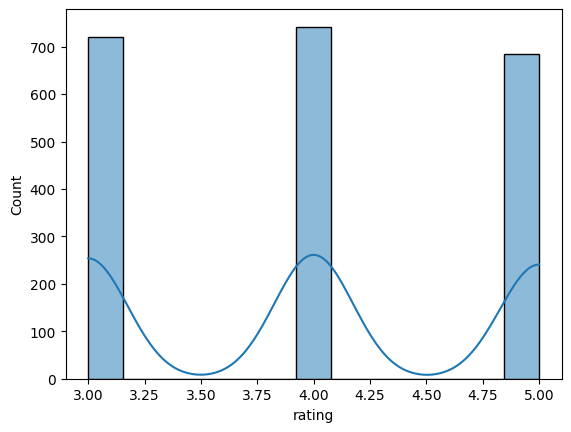

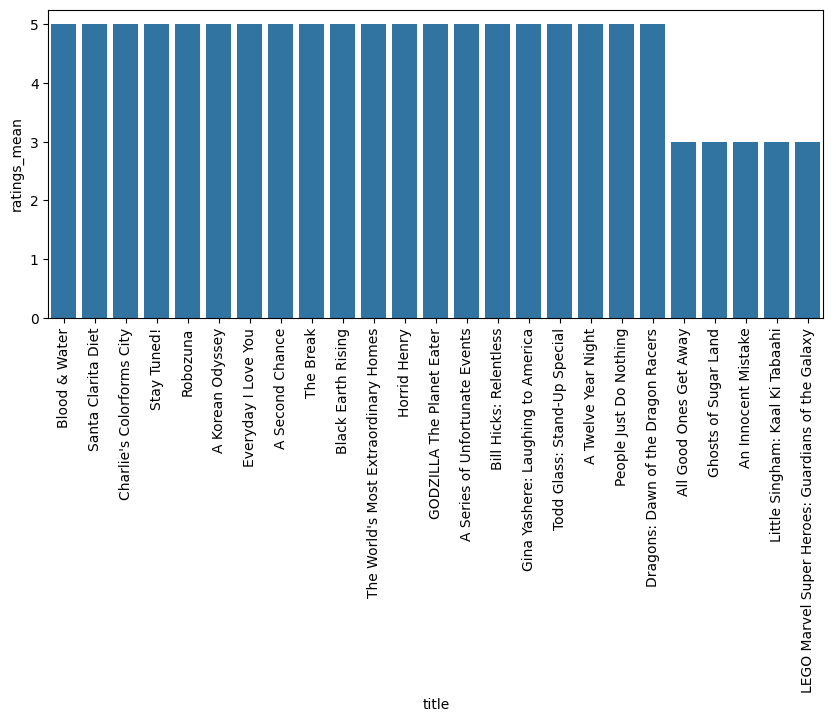

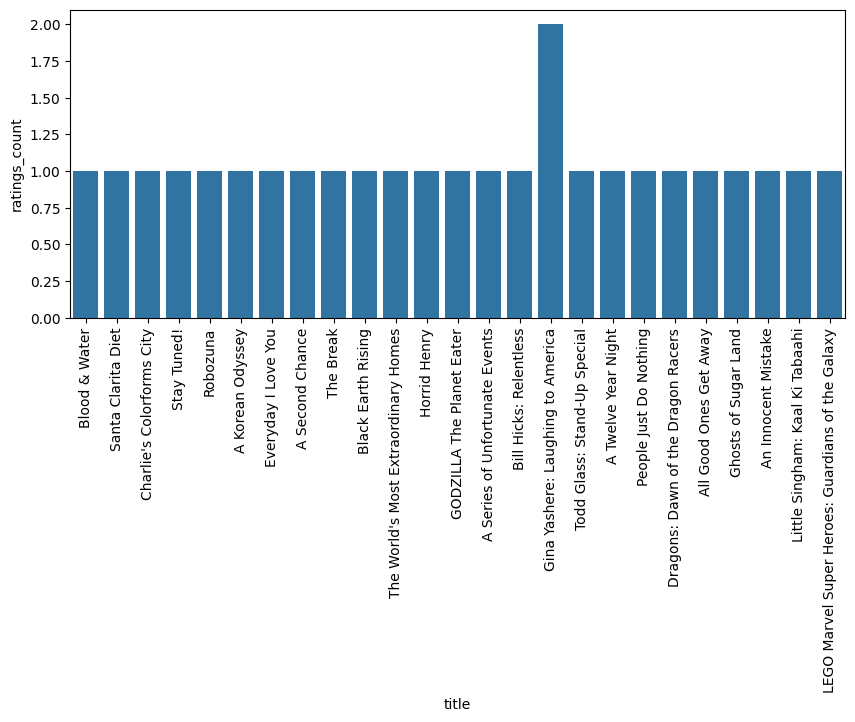

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sqlalchemy import create_engine
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate

df_ratings = pd.read_csv('movies_ratings.csv')
df_titles = pd.read_csv('movies_titles.csv')
df_users = pd.read_csv('movies_users.csv')

display(df_ratings.head())
display(df_titles.head())
display(df_users.head())
print(df_ratings.shape, df_titles.shape, df_users.shape)

sns.histplot(data=df_ratings, x='rating', kde=True)

n_ratings = len(df_ratings)
n_movies = len(df_ratings['show_id'].unique())
n_users = len(df_ratings['user_id'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")
print(f"Counts of how many times each movie was rated {df_ratings['show_id'].value_counts().value_counts()}")

print('Spread of the count shows were rated: ')
print('Min:\t\t', df_ratings['show_id'].value_counts().min())
print('Quartile 1:\t', df_ratings['show_id'].value_counts().quantile(.25))
print('Median:\t\t', df_ratings['show_id'].value_counts().quantile(.5))
print('Quartile 3:\t', df_ratings['show_id'].value_counts().quantile(.75))
print('Max:\t\t', df_ratings['show_id'].value_counts().max())

print(f"Duplicate ratings: {df_ratings.duplicated(subset=['user_id', 'show_id']).sum()}")
print(f'Nulls of each column in user: {df_users.isna().sum()}')

# Visualize the average rating for each movie

# Group the rows into individual titles and calculate the mean rating for each row
movie_stats = df_ratings.groupby(by=['show_id'])[['rating']].agg(['count', 'mean'])
movie_stats.columns = ['ratings_count', 'ratings_mean'] # Rename the columns to simplify the index

# Join with df_titles to get the titles
movie_stats = movie_stats.reset_index().merge(
    df_titles[['show_id', 'title']], 
    on='show_id', 
    how='left'
)

# Sort the ratings
movie_stats = movie_stats.sort_values(by=['ratings_mean'], ascending=False)

# Create a smaller dataset of the top n and bottom n rated movies
df_reduced = pd.concat([movie_stats.head(20), movie_stats.tail(5)])

plt.figure(figsize=(10,4)) # Set the size of the figure
sns.barplot(data=df_reduced, x='title', y='ratings_mean')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10,4)) # Set the size of the figure
sns.barplot(data=df_reduced, x='title', y='ratings_count')
plt.xticks(rotation=90)
plt.show()

         dtype  count  missing  unique  mode  min      q1  median      q3  \
user_id  int64   2147        0     200     1    1    51.0   101.0   151.0   
show_id  int64   2147        0    1809   540    2  2067.0  4125.0  6402.0   
rating   int64   2147        0       3     4    3     3.0     4.0     5.0   

          max         mean          std      skew      kurt  
user_id   200   100.693526    57.759328 -0.008979 -1.198730  
show_id  8807  4241.331626  2548.642682  0.098566 -1.141103  
rating      5     3.982767     0.808956  0.031380 -1.471180  
                                                     dtype  count  missing  \
show_id                                              int64   8508        0   
type                                                object   8508        0   
title                                               object   8508        0   
director                                            object   6394     2114   
cast                                                o

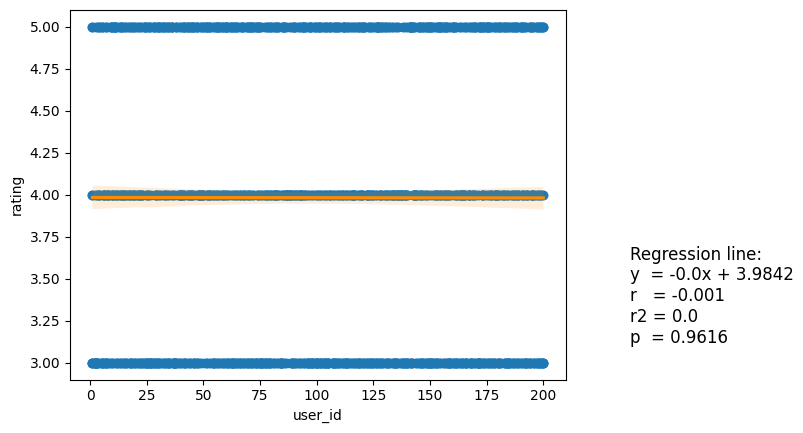

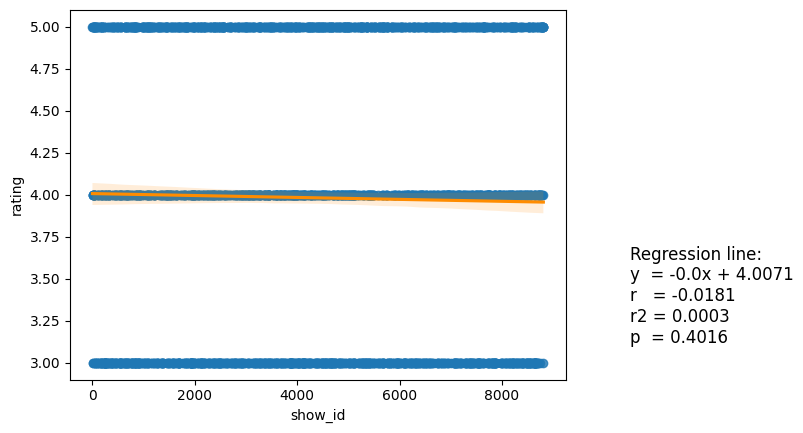

In [10]:
# Pipeline automation for the future
df_results = univariate_stats(df_ratings)
print(df_results)

df_results = univariate_stats(df_titles)
print(df_results)

df_results = bivariate(df_ratings, 'rating')

# Data Preparation

In [11]:
## df_titles.drop('director', axis=1, inplace=True)
df_titles.dropna(inplace=True)
# Make sure that the ratings dataframe includes only the shows that weren't deleted from dropping empty rows
common_ids = set(df_titles['show_id']).intersection(set(df_ratings['show_id']))
df_titles = df_titles[df_titles['show_id'].isin(common_ids)]
df_ratings = df_ratings[df_ratings['show_id'].isin(common_ids)]

# Prep user dataframe for use
df_users.drop(columns=['city','state','zip','email','name','phone'])

# To help with cold start problem, here's beysian math transformation
# Step 1: Compute global average rating (C)
C = df_ratings['rating'].mean()

# Step 2: Compute number of ratings and average rating per movie
movie_stats = df_ratings.groupby('show_id').agg(
    v=('rating', 'count'),  # number of ratings
    R=('rating', 'mean')    # average rating
).reset_index()

# Step 3: Choose a minimum number of ratings threshold (m)
m = 1  # tweak this based on your dataset

# Step 4: Compute Bayesian average
movie_stats['bayesian_rating'] = (
    (movie_stats['v'] / (movie_stats['v'] + m)) * movie_stats['R']
    + (m / (movie_stats['v'] + m)) * C
)

# Step 5: Merge back and overwrite the 'rating' column
df_ratings = df_ratings.merge(
    movie_stats[['show_id', 'bayesian_rating']],
    on='show_id',
    how='left'
)

df_ratings['rating'] = df_ratings['bayesian_rating']
df_ratings.drop(columns=['bayesian_rating'], inplace=True)

#### Data Prep for future pipeline

In [12]:
# Use the three columns with the most missing
df_titles = basic_wrangling(df_titles, features=['director', 'cast', 'country'])
display(df_titles.head())
print(df_titles.shape)
df_titles = missing_drop(df_titles, messages=False)
display(df_titles.head())
print(df_titles.shape)

Too many unique values (1026 out of 1033, 1.0) for cast


,show_id,type,title,director,country,release_year,rating,duration,description,Action,...,Language TV Shows,Musicals,Nature TV,Reality TV,Spirituality,TV Action,TV Comedies,TV Dramas,Talk Shows TV Comedies,Thrillers
29,30,Movie,Paranoia,Robert Luketic,United States India France,2013,PG-13,106 min,Blackmailed by his company's CEO a low-level e...,0,...,0,0,0,0,0,0,0,0,0,1
40,42,Movie,Jaws,Steven Spielberg,United States,1975,PG,124 min,When an insatiable great white shark terrorize...,1,...,0,0,0,0,0,0,0,0,0,0
41,43,Movie,Jaws 2,Jeannot Szwarc,United States,1978,PG,116 min,Four years after the last deadly shark attacks...,0,...,0,0,0,0,0,0,0,0,0,1
55,57,Movie,Naruto Shippuden the Movie: Blood Prison,Masahiko Murata,Japan,2011,TV-14,102 min,Mistakenly accused of an attack on the Fourth ...,1,...,0,0,0,0,0,0,0,0,0,0
56,58,Movie,Naruto Shippûden the Movie: Bonds,Hajime Kamegaki,Japan,2008,TV-PG,93 min,When strange ninjas ambush the village of Kono...,1,...,0,0,0,0,0,0,0,0,0,0


(1033, 41)


,show_id,type,title,director,country,release_year,rating,duration,description,Action,...,Language TV Shows,Musicals,Nature TV,Reality TV,Spirituality,TV Action,TV Comedies,TV Dramas,Talk Shows TV Comedies,Thrillers
29,30,Movie,Paranoia,Robert Luketic,United States India France,2013,PG-13,106 min,Blackmailed by his company's CEO a low-level e...,0,...,0,0,0,0,0,0,0,0,0,1
40,42,Movie,Jaws,Steven Spielberg,United States,1975,PG,124 min,When an insatiable great white shark terrorize...,1,...,0,0,0,0,0,0,0,0,0,0
41,43,Movie,Jaws 2,Jeannot Szwarc,United States,1978,PG,116 min,Four years after the last deadly shark attacks...,0,...,0,0,0,0,0,0,0,0,0,1
55,57,Movie,Naruto Shippuden the Movie: Blood Prison,Masahiko Murata,Japan,2011,TV-14,102 min,Mistakenly accused of an attack on the Fourth ...,1,...,0,0,0,0,0,0,0,0,0,0
56,58,Movie,Naruto Shippûden the Movie: Bonds,Hajime Kamegaki,Japan,2008,TV-PG,93 min,When strange ninjas ambush the village of Kono...,1,...,0,0,0,0,0,0,0,0,0,0


(1033, 41)


# Modeling and Evaluation

### Collaborative

In [13]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[['user_id', 'show_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

sim_options = {
    'name': 'cosine',         # or 'pearson'
    'user_based': True,       # set to False for item-based
    'min_support': 1,         # minimum common items required
    'verbose': True
}

algo = SVD()
algo.fit(trainset)

In [14]:
predictions = algo.test(testset)

# Calculate and print evaluation metrics
rmse_value = accuracy.rmse(predictions, verbose=True)
mae_value = accuracy.mae(predictions, verbose=True)
results = cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

RMSE: 0.3982
MAE:  0.3288
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4052  0.3957  0.3840  0.4205  0.4033  0.4017  0.0120  
MAE (testset)     0.3386  0.3286  0.3138  0.3593  0.3353  0.3351  0.0148  
Fit time          0.04    0.01    0.01    0.01    0.01    0.02    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


### Content (with some extra data prep)

In [15]:
genre_cols = [col for col in df_titles.columns if df_titles[col].dtype == 'int64' and col not in ['release_year']]

# Create feature matrix: genre dummies + normalized release_year + rating encoding
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Normalize release_year
scaler = MinMaxScaler()
df_titles['release_year_scaled'] = scaler.fit_transform(df_titles[['release_year']].fillna(0))

# One-hot encode 'rating' column
rating_encoded = pd.get_dummies(df_titles['rating'].fillna('Unknown'), prefix='rating')

# Final feature matrix
feature_matrix = pd.concat([
    df_titles[genre_cols],
    df_titles[['release_year_scaled']],
    rating_encoded
], axis=1)

feature_matrix.index = df_titles['show_id']
content_similarity = cosine_similarity(feature_matrix)
content_sim_df = pd.DataFrame(content_similarity, index=feature_matrix.index, columns=feature_matrix.index)



In [16]:
precision = precision_at_k(content_sim_df, df_titles, genre_cols, k=5)
print(f"Average Precision: {precision:.3f}")

Average Precision: 0.964


### Content on Genre and past user ratings

In [17]:
# Step 1: Identify genre columns
genre_cols = [col for col in df_titles.columns if df_titles[col].dropna().isin([0, 1]).all() and col not in ['release_year']]
genre_cols = [col for col in genre_cols if df_titles[col].sum() > 0]  # remove any columns with all 0s

# Step 2: Merge with ratings to limit to rated content (if desired)
df_full = df_titles[df_titles['show_id'].isin(df_ratings['show_id'])].copy()
df_full = df_full.reset_index(drop=True)

# Step 3: Compute cosine similarity on genre vectors
from sklearn.metrics.pairwise import cosine_similarity
genre_matrix = df_full[genre_cols].fillna(0).values
cosine_sim = cosine_similarity(genre_matrix)

# Step 4: Build recommendation entries
recs = []
for idx, row in df_full.iterrows():
    show_id = row['show_id']
    genres = [g for g in genre_cols if row[g] == 1]
    genre_string = ', '.join(genres)

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]  # skip self

    for rec_idx, score in sim_scores:
        recs.append({
            'show_id': show_id,
            'recommended_id': df_full.at[rec_idx, 'show_id'],
            'genre': genre_string,
            'score': float(score)
        })

# Step 5: Convert to DataFrame
df_genre_recs = pd.DataFrame(recs)

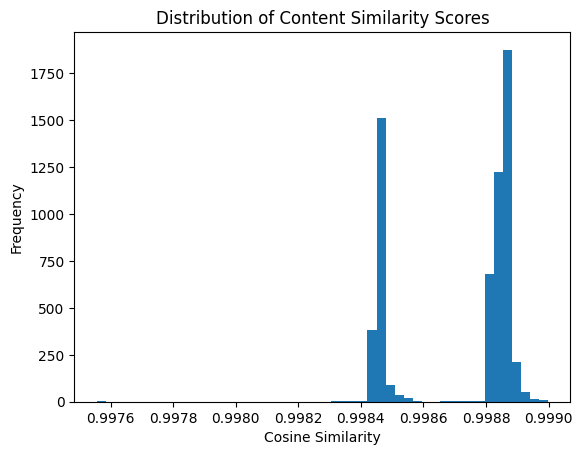

In [18]:
# Flatten the similarity matrix and remove self-similarity values (near 1.0)
sim_values = content_sim_df.values.flatten()
sim_values = sim_values[sim_values < 0.999]

plt.hist(sim_values, bins=50)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Content Similarity Scores")
plt.show()

# Deployment

### First, we have a collabortively trained deployment based on user_id

In [19]:
# Get list of all user_ids and show_ids from the training set
# Get mappings from inner to raw IDs
user_inner_to_raw = trainset.to_raw_uid
item_inner_to_raw = trainset.to_raw_iid

all_user_ids = trainset.all_users()
all_item_ids = trainset.all_items()
top_n = 25  # top-N recommendations per user

rows = []

for inner_uid in all_user_ids:
    raw_uid = int(user_inner_to_raw(inner_uid))
    
    # Get items already rated
    rated_items = set(item_inner_to_raw(iid) for (iid, _) in trainset.ur[inner_uid])
    
    preds = []
    for inner_iid in all_item_ids:
        raw_iid = item_inner_to_raw(inner_iid)
        if raw_iid not in rated_items:
            pred = algo.predict(str(raw_uid), str(raw_iid))
            preds.append((raw_iid, pred.est))
    
    # Get top-N
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
    
    for show_id, score in top_preds:
        rows.append({
            'show_id': show_id,
            'distance': round(score, 3),
            'user_id': raw_uid
        })

engine = create_engine('sqlite:///recommender.db')

df_top10_user = pd.DataFrame(rows)
df_top10_user.to_sql(
    'top10_userId', 
    con=engine, 
    if_exists='replace',  # or 'append' if you want to keep old rows
    index=False
)

4775

### Content deployment of shows, based on genre, year, and rating

In [20]:
content_sim_df_reset = content_sim_df.reset_index()  # 'show_id' becomes a column

engine = create_engine('sqlite:///recommender.db')

content_sim_df_reset.to_sql('content_recs1', con=engine, if_exists='replace', index=False)

1033

### Deployment of genre based on user ratings show recommendations

In [21]:

# Step 1: Create SQLAlchemy engine for SQLite
engine = create_engine('sqlite:///recommender.db')

# Step 2: Write DataFrame to the genre_recommendations table
df_genre_recs.to_sql('genre_recommendations', con=engine, if_exists='replace', index=False)


5165